In [32]:
try:
  # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
   
    print(a)
except Exception:
  pass

In [33]:
import tensorflow as tf

tf.random.set_seed(0)

In [34]:
import numpy as np
import pandas as pd

train_data=np.genfromtxt('./ocr/train-data.csv',delimiter=',', dtype= "float64")
train_class=pd.read_csv('./ocr/train-target.csv',header=None)
# test_data=np.genfromtxt('../../ocr/test-data.csv',delimiter=',', dtype= "float64")
# test_class=pd.read_csv('../../ocr/test-target.csv',header=None)

train_data=np.reshape(train_data,(-1,16,8))

# test_data=np.reshape(test_data,(-1,16,8))

train_x=tf.convert_to_tensor(train_data)
# test_x=tf.convert_to_tensor(test_data)

<Figure size 432x288 with 0 Axes>

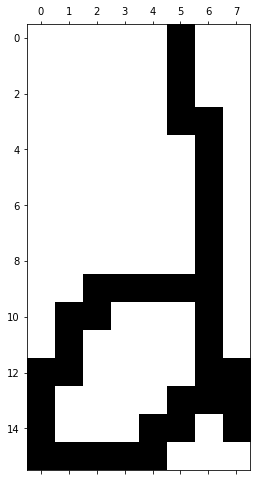

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.gray()
plt.matshow(255 - train_data[0]) # 255 - x simply inverts the fading direction of the image
plt.show()
# train_data[0]

In [36]:
alfa=list(train_class[0].value_counts().index)
alfa.sort()
alfa_dict_num_to_char={i:char for i,char in enumerate(alfa)}
alfa_dict_char_to_num={char:i for i,char in enumerate(alfa)}

train_class_conv=np.zeros((train_class.shape[0],26),dtype=int)
# test_class_conv=np.zeros((test_class.shape[0],26),dtype=int)

for i,char in enumerate(train_class[0]):
    train_class_conv[i][alfa_dict_char_to_num[char]]=1
    
# for i,char in enumerate(test_class[0]):
#     test_class_conv[i][alfa_dict_char_to_num[char]]=1
    
train_y=tf.convert_to_tensor(train_class_conv)
# test_y=tf.convert_to_tensor(test_class_conv)

In [37]:
def train_step(images, labels, model, loss_fn, optimizer):
  with tf.GradientTape() as tape: # all the operations within this scope will be recorded in tape
    predictions = model(images, training=True)
    loss = loss_fn(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss_metric(loss)
  train_accuracy_metric(labels, predictions)

In [38]:
from datetime import datetime

def train_loop(epochs, train_ds, model, loss_fn, optimizer):
  for epoch in range(epochs):
      # reset the metrics for the next epoch
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()

    start = datetime.now() # save start time 
    for images, labels in train_ds:
      train_step(images, labels, model, loss_fn, optimizer)

    template = 'Epoch {}, Time {}, Loss: {}, Accuracy: {}'
    print(template.format(epoch+1,
                          datetime.now() - start,
                          train_loss_metric.result(),
                          train_accuracy_metric.result()*100))

In [39]:
def test_step(images, labels, model, loss_fn):
  predictions = model(images, training=False)
  t_loss = loss_fn(labels, predictions)

  test_loss_metric(t_loss)
  test_accuracy_metric(labels, predictions)

In [40]:
def test_loop(test_ds, model, loss_fn):
    # reset the metrics for the next epoch
  test_loss_metric.reset_states()
  test_accuracy_metric.reset_states()
 
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels, model, loss_fn)

  template = 'Test Loss: {}, Test Accuracy: {}'
  print(template.format(test_loss_metric.result(),
                        test_accuracy_metric.result()*100))

In [41]:
from tensorflow.keras import Model

class HWCharConvolutional(Model):
  def __init__(self, in_channels, out_channels, size):
    super().__init__() # setup the moedl basic functionalities (mandatory)
    initial = tf.random.truncated_normal([size, size, in_channels, out_channels], stddev=0.1)
    self.filters = tf.Variable(initial) # create weights for the filters

  def call(self, x):
    res = tf.nn.conv2d(x, self.filters, 1, padding="SAME")
    return res

class HWCharFullyConnected(Model):
  def __init__(self, input_shape, output_shape):
    super().__init__() # initialize the model
    self.W = tf.Variable(tf.random.truncated_normal([input_shape, output_shape], stddev=0.1)) # declare weights 
    self.b = tf.Variable(tf.constant(0.1, shape=[1, output_shape]))  # declare biases
    
  def call(self, x):
    res = tf.matmul(x, self.W) + self.b 
    return res


In [42]:
from tensorflow.keras.layers import MaxPool2D, Dropout, Flatten, Softmax

class HWCharDeepModel(Model):
  def __init__(self, k):
    super().__init__()                            #input shape: (batch, 16, 8, 1)
    self.conv1 = HWCharConvolutional(1, 32, k)  # out shape : (batch, 16, 8, 32)
    self.pool1 = MaxPool2D([2,2])                 # out shape : (batch, 8, 4, 32)
    self.conv2 = HWCharConvolutional(32, 64, k) # out shape : (batch, 8, 4, 64)
    self.pool2 = MaxPool2D([2,2])                 # out shape : (batch, 4, 2, 64)
    self.conv3 = HWCharConvolutional(64, 128, k)
    self.pool3 = MaxPool2D([2,2])
    self.flatten = Flatten()                      # out shape : (batch, 2*1*128)
    self.fc1 = HWCharFullyConnected(1*2*128, 512)  # out shape : (batch, 1024)
    self.dropout = Dropout(0.5)                   # out shape : unchanged
    self.fc2 = HWCharFullyConnected(512, 26)      # out shape : (batch, 26)
    self.softmax = Softmax()                      # out shape : unchanged

  def call(self, x, training=False):
    x = tf.nn.relu(self.conv1(x))
    x = self.pool1(x)
    x = tf.nn.relu(self.conv2(x))
    x = self.pool2(x)
    x = tf.nn.relu(self.conv3(x))
    x = self.pool3(x)
    x = self.flatten(x)
    x = tf.nn.relu(self.fc1(x))

    x = self.dropout(x, training=training) # behavior of dropout changes between train and test
    
    x = self.fc2(x)
    prob = self.softmax(x)
    
    return prob


In [43]:
def model_sel(epochs,  max_node_number, batch_size_max, lrs, ms_train_x, 
              ms_train_y, ms_val_x, ms_val_y, select_n_node=False, select_bs=False):
    '''
    This function perform the model selection training a model based on the given parameters:
    
    epochs= number of epochs for the training
    
    max_node_number= the maximal number of node for the Convolutional layers, it will be 
                     tested the range from 5 to max_node_number, with steps of length 5
                     
    batch_size_max= the maximal exponent of 2 for barch size (2, 4, 8, 16, 32, 64...), it
                    will be tested the range from 6 to batch_size_max. 
    
    lrs= the minimal negative exponent of 10 for learning rate (0.1, 0.01, 0.001....), it
         will be tested the range from 2 to lrs
         
    There's 2 boolean parameters of the function, 'select_n_node' and 'select_bs' that are for
    choosing to selecting the number of node and batch size respectively, default=False.
    '''
    
    
    
    max_acc=0
    min_loss=1000
    hyp_params=[0,0,0,0]
    
    if select_n_node and select_bs:
        
        for node_number in range(5,max_node_number,5):

            print('Node number= {}'.format(str(node_number)))

            for batch_size in range(6,batch_size_max):

                print('Batch size= train: {}, test: {}'.format(str(2**(batch_size+1)),str(2**(batch_size))))
                ms_train_ds=tf.data.Dataset.from_tensor_slices(
                    (train_x, train_y)).shuffle(7000).batch(2**(batch_size+1))

                ms_val_ds=tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(2**(batch_size))

                for lr in range(2,lrs):

                    print('Learning rate= {}'.format(str(10**(-lr))))

                    learning_rate=10**(-lr)
                    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                    loss_fn = tf.keras.losses.CategoricalCrossentropy()
                    model=HWCharDeepModel(node_number)

                    for epoch in range(epochs):
                        # reset the metrics for the next epoch
                        train_loss_metric.reset_states()
                        train_accuracy_metric.reset_states()
                        test_loss_metric.reset_states()
                        test_accuracy_metric.reset_states()

                        for images, labels in ms_train_ds:
                            train_step(images, labels, model, loss_fn, optimizer)

                        for val_images, val_labels in ms_val_ds:
                            test_step(val_images, val_labels, model, loss_fn)

                        if test_accuracy_metric.result()*100>max_acc and test_loss_metric.result()<min_loss:
                            min_loss=test_loss_metric.result()
                            max_acc=test_accuracy_metric.result()
                            hyp_params=[node_number,batch_size,lr,epochs+1]

                            template = 'Epoch {}, Loss: {}, Accuracy: {}, Val_Loss: {}, Val_Accuracy: {}'
                            print(template.format(epoch+1,
                                                  train_loss_metric.result(),
                                                  train_accuracy_metric.result()*100,
                                                  test_loss_metric.result(),
                                                  test_accuracy_metric.result()*100))
    elif select_bs:
    #     print(max_acc)
        
        node_number=max_node_number
        
        print('Node number= {}'.format(str(node_number)))

        for batch_size in range(6,batch_size_max):

            print('Batch size= train: {}, test: {}'.format(str(2**(batch_size+1)),str(2**(batch_size))))
            ms_train_ds=tf.data.Dataset.from_tensor_slices(
                (train_x, train_y)).shuffle(7000).batch(2**(batch_size+1))

            ms_val_ds=tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(2**(batch_size))

            for lr in range(2,lrs):

                print('Learning rate= {}'.format(str(10**(-lr))))

                learning_rate=10**(-lr)
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                loss_fn = tf.keras.losses.CategoricalCrossentropy()
                model=HWCharDeepModel(node_number)

                for epoch in range(epochs):
                    # reset the metrics for the next epoch
                    train_loss_metric.reset_states()
                    train_accuracy_metric.reset_states()
                    test_loss_metric.reset_states()
                    test_accuracy_metric.reset_states()
                    for images, labels in ms_train_ds:
                        train_step(images, labels, model, loss_fn, optimizer)

                    for val_images, val_labels in ms_val_ds:
                        test_step(val_images, val_labels, model, loss_fn)

                    if test_accuracy_metric.result()*100>max_acc and test_loss_metric.result()<min_loss:
                        min_loss=test_loss_metric.result()
                        max_acc=test_accuracy_metric.result()
                        hyp_params=[node_number,batch_size,lr,epochs+1]

                        template = 'Epoch {}, Loss: {}, Accuracy: {}, Val_Loss: {}, Val_Accuracy: {}'
                        print(template.format(epoch+1,
                                              train_loss_metric.result(),
                                              train_accuracy_metric.result()*100,
                                              test_loss_metric.result(),
                                              test_accuracy_metric.result()*100))
    elif select_n_node:
        for node_number in range(5,max_node_number,5):

            print('Node number= {}'.format(str(node_number)))

            batch_size=batch_size_max

            print('Batch size= train: {}, test: {}'.format(str(2**(batch_size+1)),str(2**(batch_size))))
            ms_train_ds=tf.data.Dataset.from_tensor_slices(
                (train_x, train_y)).shuffle(7000).batch(2**(batch_size+1))

            ms_val_ds=tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(2**(batch_size))

            for lr in range(2,lrs):

                print('Learning rate= {}'.format(str(10**(-lr))))

                learning_rate=10**(-lr)
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                loss_fn = tf.keras.losses.CategoricalCrossentropy()
                model=HWCharDeepModel(node_number)

                for epoch in range(epochs):
                    # reset the metrics for the next epoch
                    train_loss_metric.reset_states()
                    train_accuracy_metric.reset_states()
                    test_loss_metric.reset_states()
                    test_accuracy_metric.reset_states()

                    for images, labels in ms_train_ds:
                        train_step(images, labels, model, loss_fn, optimizer)

                    for val_images, val_labels in ms_val_ds:
                        test_step(val_images, val_labels, model, loss_fn)

                    if test_accuracy_metric.result()*100>max_acc and test_loss_metric.result()<min_loss:
                        min_loss=test_loss_metric.result()
                        max_acc=test_accuracy_metric.result()
                        hyp_params=[node_number,batch_size,lr,epochs+1]

                        template = 'Epoch {}, Loss: {}, Accuracy: {}, Val_Loss: {}, Val_Accuracy: {}'
                        print(template.format(epoch+1,
                                                train_loss_metric.result(),
                                              train_accuracy_metric.result()*100,
                                              test_loss_metric.result(),
                                              test_accuracy_metric.result()*100))
                        
    elif (not select_n_node) and (not select_bs):
        node_number=max_node_number
        
        print('Node number= {}'.format(str(node_number)))

        batch_size=batch_size_max

        print('Batch size= train: {}, test: {}'.format(str(2**(batch_size+1)),str(2**(batch_size))))
        ms_train_ds=tf.data.Dataset.from_tensor_slices(
            (train_x, train_y)).shuffle(7000).batch(2**(batch_size+1))

        ms_val_ds=tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(2**(batch_size))

        for lr in range(2,lrs):

            print('Learning rate= {}'.format(str(10**(-lr))))

            learning_rate=10**(-lr)
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            loss_fn = tf.keras.losses.CategoricalCrossentropy()
            model=HWCharDeepModel(node_number)

            for epoch in range(epochs):
                # reset the metrics for the next epoch
                train_loss_metric.reset_states()
                train_accuracy_metric.reset_states()
                test_loss_metric.reset_states()
                test_accuracy_metric.reset_states()
                for images, labels in ms_train_ds:
                    train_step(images, labels, model, loss_fn, optimizer)

                for val_images, val_labels in ms_val_ds:
                    test_step(val_images, val_labels, model, loss_fn)

                if test_accuracy_metric.result()*100>max_acc and test_loss_metric.result() <min_loss:
                    min_loss=test_loss_metric.result()
                    max_acc=test_accuracy_metric.result()
                    hyp_params=[node_number,2**(batch_size+1),10**(-lr),epoch+1]

                    template = 'Epoch {}, Loss: {}, Accuracy: {}, Val_Loss: {}, Val_Accuracy: {}'
                    print(template.format(epoch+1,
                                          train_loss_metric.result(),
                                          train_accuracy_metric.result()*100,
                                          test_loss_metric.result(),
                                          test_accuracy_metric.result()*100))
    return hyp_params

In [44]:
train_x = train_x[..., tf.newaxis]
# test_x = test_x[..., tf.newaxis]

#train set split in train set and validation set for the model selection

ms_train_x,ms_val_x=tf.split(train_x,[int(len(train_x)*0.7),len(train_x)-int(len(train_x)*0.7)])
ms_train_y,ms_val_y=tf.split(train_y,[int(len(train_y)*0.7),len(train_y)-int(len(train_y)*0.7)])


In [45]:
train_loss_metric = tf.keras.metrics.Mean()
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

test_loss_metric = tf.keras.metrics.Mean()
test_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

In [46]:
selected_hyp_params=model_sel(35,  5, 6, 5, ms_train_x, ms_train_y, ms_val_x, ms_val_y)

Node number= 5
Batch size= train: 128, test: 64
Learning rate= 0.01

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.8612357974052429, Accuracy: 74.82563018798828, Val_Loss: 0.4744853377342224, Val_Accuracy: 86.39631652832031
Epoch 2, Loss: 0.43757057189941406, Accuracy: 87.30136108398438, Val_Loss: 0.46264883875846863, Val_Accuracy: 87.10574340820312
Epoch 3, Loss: 0.40247872471809387, Accuracy: 88.19539642333984, Val_Loss: 0.39864471554756165, Val_Accuracy: 88.41913604736328
Epoch 4, Loss: 0.4016132056713104, Accuracy: 88.4973983764

In [47]:
selected_hyp_params

[5, 128, 0.001, 6]

In [ ]:
network_loss = tf.keras.losses.CategoricalCrossentropy()

network_optimizer = tf.keras.optimizers.Adam(learning_rate=selected_hyp_params[2])

train_loss_metric = tf.keras.metrics.Mean()
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

test_loss_metric = tf.keras.metrics.Mean()
test_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_x, train_y)).shuffle(10000).batch(selected_hyp_params[1])

test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(selected_hyp_params[1]//2)


In [ ]:
EPOCHS = selected_hyp_params[3]
network=HWCharDeepModel(selected_hyp_params[0])
train_loop(EPOCHS, train_ds,  network, network_loss, network_optimizer)

In [ ]:
test_loop(test_ds, network, network_loss)

In [ ]:
predicted_class=network(test_x,training=False)

list_of_predicted_class=[]
for i in predicted_class:
    ind=int(tf.argmax(i))
    list_of_predicted_class.append(alfa_dict_num_to_char[ind])
# list_of_predicted_class

file = open('predicted_class.txt', 'w')

for char in list_of_predicted_class:
    file.write(char+'\n')

file.close()